## 0. 모듈 불러오기

In [ ]:
import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

import pickle
import cv2
import mediapipe as mp

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow import keras

from keras.callbacks import ModelCheckpoint

from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D,\
                        Permute, TimeDistributed, Bidirectional,GRU, LeakyReLU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Reshape
from keras import models
from keras import layers
import tensorflow as tf

## 1. 영상 데이터 확인

In [ ]:
Main_Video_Path = Path('C:/Users/HOME/Desktop/AI_project/KSL/KSL_ACTION_VIDEO')
Video_Path = list(Main_Video_Path.glob(r'*/*.MP4'))
Video_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Video_Path))
Video_Path_Series = pd.Series(Video_Path,name='MP4').astype(str)
Video_Labels_Series = pd.Series(Video_Labels,name='CATEGORY')
video_df = pd.concat([Video_Path_Series,Video_Labels_Series],axis=1)

In [ ]:
video_df.sort_values(by=['CATEGORY'],ignore_index=True,inplace=True)

In [ ]:
video_df

,MP4,CATEGORY
0,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
1,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
2,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
3,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
4,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
...,...,...
1224,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,77
1225,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,77
1226,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,77
1227,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,77


In [ ]:
video_df.groupby('CATEGORY').agg('count')

,MP4
CATEGORY,
01,20
02,20
03,20
04,20
05,19
...,...
71,14
72,19
74,20


- 라벨(카테고리)는 총 67개

<AxesSubplot:xlabel='CATEGORY', ylabel='count'>

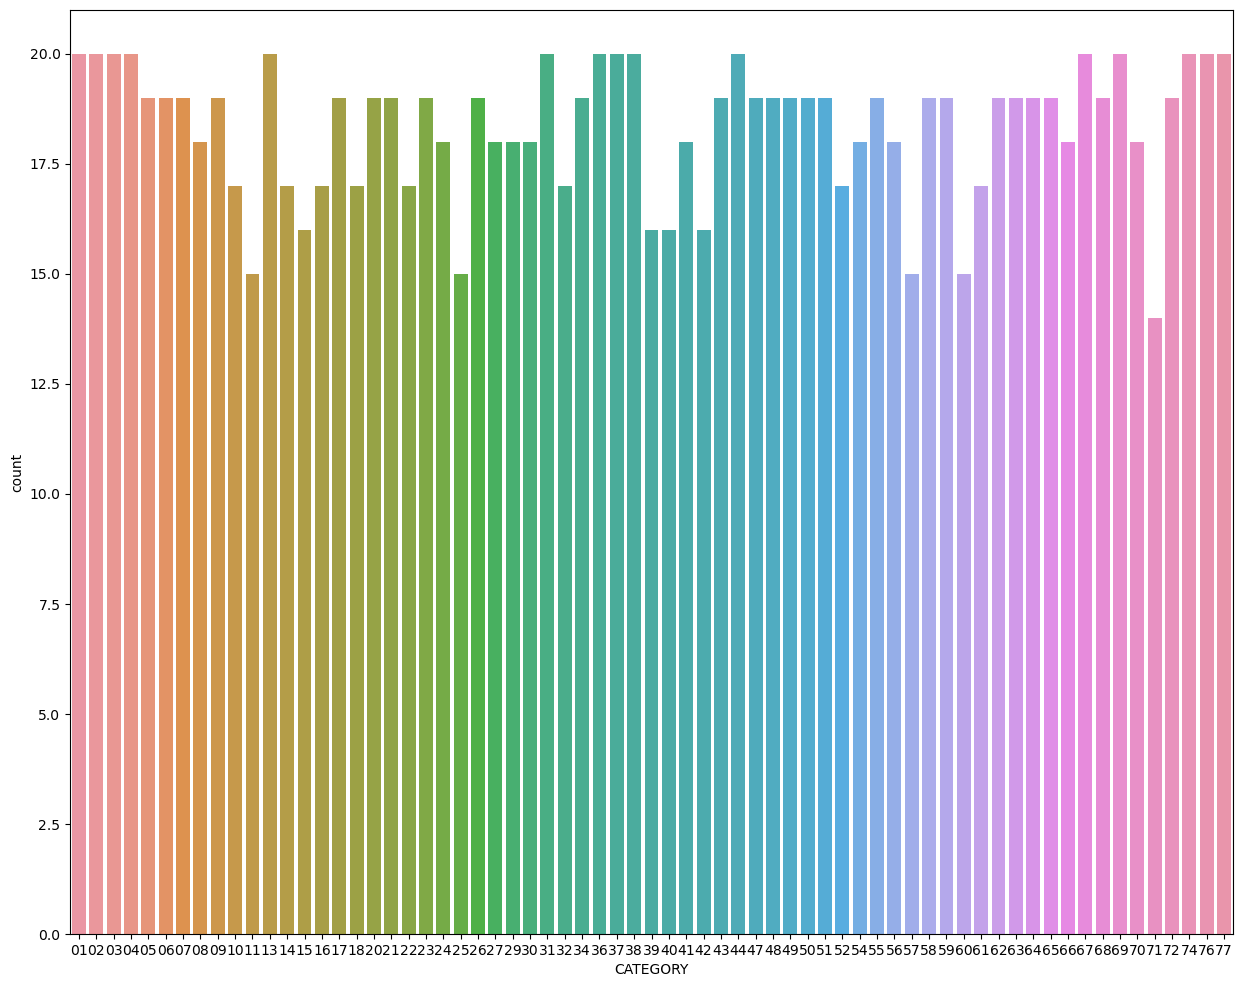

In [ ]:
plt.figure(figsize=(15,12))
sns.countplot(data=video_df, x='CATEGORY')

### 선정한 10개 단어만 분리

In [ ]:
video_df_slct=video_df[(video_df['CATEGORY']=='15')|(video_df['CATEGORY']=='13')|(video_df['CATEGORY']=='60')|
                       (video_df['CATEGORY']=='01')|(video_df['CATEGORY']=='07')|(video_df['CATEGORY']=='55')|
                       (video_df['CATEGORY']=='77')|(video_df['CATEGORY']=='11')|(video_df['CATEGORY']=='16')|
                       (video_df['CATEGORY']=='17')]
video_df_slct

,MP4,CATEGORY
0,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
1,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
2,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
3,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
4,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,01
...,...,...
1224,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,77
1225,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,77
1226,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,77
1227,C:\Users\HOME\Desktop\AI_project\KSL\KSL_ACTIO...,77


In [ ]:
video_df_slct.groupby('CATEGORY').agg('count')

,MP4
CATEGORY,
01,20
07,19
11,15
13,20
15,16
16,17
17,19
55,19
60,15


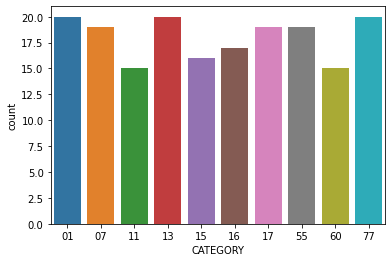

In [ ]:
sns.countplot(data=video_df_slct, x='CATEGORY')

- 라벨별로 14~20개의 영상이 존재함

## 2. 이미지(프레임) 데이터 확인 및 전처리

### 파일에 대한 정보를 데이터프레임으로 만들기

In [ ]:
directory = "C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb"

In [ ]:
Class_name = os.listdir(directory)

In [ ]:
data = []
for i in Class_name:
    path = os.path.join(directory, i)
    file_list = os.listdir(path)
    
    for j in file_list:
        name = j
        label1 = i
        label2 = i[3:5]
        num = j[6:10]
    
        eda = [name, label1, label2, num]
        data.append(eda)

In [ ]:
DF=pd.DataFrame(data, columns=['name','fold','class','num'])
DF['path']=directory+'/'+DF['fold']+'/'+DF['name']

In [ ]:
##선정한 10개 데이터만 선택
DF_select=DF[(DF['class']=='15')|(DF['class']=='13')|(DF['class']=='60')|(DF['class']=='01')|(DF['class']=='07')|
             (DF['class']=='55')|(DF['class']=='77')|(DF['class']=='11')|(DF['class']=='16')|(DF['class']=='17')]
DF_select['class']=DF_select['class'].astype(int)
DF_select['num']=DF_select['num'].astype(int)

In [ ]:
with open('C:/Users/HOME/Desktop/AI_project/KSL/class_label.p','rb') as f:
    Labels=pickle.load(f)

In [ ]:
DF_label=pd.DataFrame({'class' : Labels.keys(),'label' : Labels.values()})

In [ ]:
#파일에 대한 최종 데이터프레임
DF_select = pd.merge(DF_select, DF_label, on='class')
DF_select

,name,fold,class,num,path,label
0,00_01.0001.jpg,00_01,1,1,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
1,00_01.0002.jpg,00_01,1,2,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
2,00_01.0003.jpg,00_01,1,3,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
3,00_01.0004.jpg,00_01,1,4,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
4,00_01.0005.jpg,00_01,1,5,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
...,...,...,...,...,...,...
16214,19_77.0123.jpg,19_77,77,123,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/1...,care
16215,19_77.0124.jpg,19_77,77,124,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/1...,care
16216,19_77.0125.jpg,19_77,77,125,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/1...,care
16217,19_77.0126.jpg,19_77,77,126,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/1...,care


- name : 파일명
- fold : 폴더명
- class : 클래스명(숫자)
- num : 몇번째 프레임인지
- path : 경로
- label : 클래스명(뜻)

### 미디어파이프
- 손 모양이 중요하므로 손에 대한 정보를 추출하기 위해 진행
- 미디어파이프 적용된 이미지는 따로 폴더에 저장

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [ ]:
lmList = []

with mp_hands.Hands(
    static_image_mode=True, #움직임 없는 이미지 인식
    max_num_hands=2, #최대 인식 손 개수
    min_detection_confidence=0.5) as hands:
    for file in select_df['path']:
        image = cv2.flip(cv2.imread(file), 1)
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        print('Handedness:', results.multi_handedness)
        if not results.multi_hand_landmarks:
            continue
        image_height, image_width, _ = image.shape
        annoted_image = image.copy()
        for hand_landmarks in results.multi_hand_landmarks:
            print('hand_landmarks:', hand_landmarks)
            lmList.append([
                file[-14:-4]+'.jpg',
                hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].x * image_width, 
                hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y * image_height,
                hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width, 
                hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height,
                hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].x * image_width, 
                hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y * image_height,
                hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].x * image_width, 
                hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].y * image_height,
                hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].x * image_width, 
                hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].y * image_height,
            ])
            

            mp_drawing.draw_landmarks(
              annoted_image,
              hand_landmarks,
              mp_hands.HAND_CONNECTIONS,
              mp_drawing_styles.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
              mp_drawing_styles.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
            cv2.imwrite(
            'C:/Users/HOME/Desktop/AI_project/KSL/KSL_mp_3600/' + file[-14:-4] + '.jpg', cv2.flip(annoted_image, 1))

In [ ]:
#파일명,엄지손가락x좌표,엄지손가락y좌표......새끼손가락x좌표,새끼손가락y좌표
pd.DataFrame(lmList, columns=['name','thumb_x','thumb_y','index_x','index_y','middle_x','middle_y','ring_x','ring_y','pinky_x','pinky_y']).head()

,name,thumb_x,thumb_y,index_x,index_y,middle_x,middle_y,ring_x,ring_y,pinky_x,pinky_y
0,00_01.0046.jpg,146.054169,83.985329,148.195770,90.121422,150.510498,92.527527,152.951202,93.261421,156.658066,91.576355
1,00_01.0047.jpg,146.592285,86.029869,148.484238,83.289421,151.111496,88.970001,154.152359,90.922333,157.715210,91.416679
2,00_01.0048.jpg,149.894150,93.380455,147.515060,92.055321,150.546951,92.396873,153.623566,93.212265,156.802139,93.088387
3,00_01.0049.jpg,149.160004,94.140656,148.358292,90.409233,150.847076,95.667648,153.752213,96.122932,157.373825,95.369423
4,00_07.0035.jpg,128.973709,122.620193,114.785782,122.874641,113.314781,127.133591,112.632797,133.263458,114.268280,142.579300


### 중요 동작 20개씩 뽑아내기

(사진 보여주면서) 프레임들 속에는 아무 동작을 하지 않는 사진들도 있어서 중요 동작들만 뽑아냄

In [ ]:
#한 폴더당 중심 동작 20개씩 뽑음
select_df=pd.read_csv('C:/Users/HOME/Desktop/AI_project/KSL/DF_select.csv')
select_df

,name,fold,class,num,path,label
0,00_01.0045.jpg,00_01,1,45,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
1,00_01.0046.jpg,00_01,1,46,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
2,00_01.0047.jpg,00_01,1,47,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
3,00_01.0048.jpg,00_01,1,48,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
4,00_01.0049.jpg,00_01,1,49,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/0...,hi
...,...,...,...,...,...,...
3595,19_77.0072.jpg,19_77,77,72,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/1...,care
3596,19_77.0073.jpg,19_77,77,73,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/1...,care
3597,19_77.0074.jpg,19_77,77,74,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/1...,care
3598,19_77.0075.jpg,19_77,77,75,C:/Users/HOME/Desktop/AI_project/KSL/KSL_rgb/1...,care


### 모델링 전 최종 전처리

In [ ]:
datagen = ImageDataGenerator(rescale=1/ 255, validation_split=0.3)
#255로 나누어 정규화.
#train:valid set 비율은 7:3

In [ ]:
train_generator = datagen.flow_from_dataframe(
          dataframe=select_df,
          batch_size=24,
          class_mode='categorical',
          shuffle=True,
          seed=2022,
          x_col='path',
          y_col='label',
          subset = 'training',)

valid_generator = datagen.flow_from_dataframe(
          dataframe=select_df,
          batch_size=24,
          class_mode='categorical',
          shuffle=True,
          seed=2022,
          x_col='path',
          y_col='label',
          subset = 'validation')

Found 2520 validated image filenames belonging to 10 classes.
Found 1080 validated image filenames belonging to 10 classes.


- train dataset : 2520개
- validation dataset : 1080개

## 3. 모델링 (미디어파이프 미적용)

### CNN(+batchnormalization)
- 가설1. 미디어파이프 적용 vs 미적용
- 아래 코드는 미디어 파이프 적용X

In [ ]:
pool_size = 2
    
model1 = Sequential([
  keras.Input(shape=(256,256,3)),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),                                           
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 80, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 80, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  MaxPooling2D(pool_size=pool_size),                         

  Flatten(),
  Dense(50),
  Activation('relu'),                                          
  
  Dense(10, activation='softmax'),
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 30)      840       
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 30)     120       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 256, 256, 30)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 30)      8130      
                                                                 
 batch_normalization_7 (Batc  (None, 256, 256, 30)     120       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 256, 256, 30)     

In [ ]:
model1.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
history1= model1.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    shuffle=True)

Epoch 1/15
11/11 [==============================] - 128s 12s/step - loss: 2.5131 - accuracy: 0.1220 - val_loss: 2.3140 - val_accuracy: 0.1111
Epoch 2/15
11/11 [==============================] - 130s 12s/step - loss: 2.3019 - accuracy: 0.1087 - val_loss: 2.3028 - val_accuracy: 0.0889
Epoch 3/15
11/11 [==============================] - 137s 12s/step - loss: 2.3015 - accuracy: 0.1109 - val_loss: 2.3030 - val_accuracy: 0.1111
Epoch 4/15
11/11 [==============================] - 130s 12s/step - loss: 2.3022 - accuracy: 0.1028 - val_loss: 2.3031 - val_accuracy: 0.1111
Epoch 5/15
11/11 [==============================] - 144s 13s/step - loss: 2.2982 - accuracy: 0.1228 - val_loss: 2.3048 - val_accuracy: 0.0889
Epoch 6/15
11/11 [==============================] - 147s 14s/step - loss: 2.2442 - accuracy: 0.1834 - val_loss: 2.3835 - val_accuracy: 0.1156
Epoch 7/15
11/11 [==============================] - 145s 13s/step - loss: 1.8985 - accuracy: 0.3417 - val_loss: 3.6735 - val_accuracy: 0.0844
Epoch 

- 최고 val_accuracy는 0.1467
- val_loss가 높아지는 것으로 보아 train에 대해서 과적합되는 것으로 보임

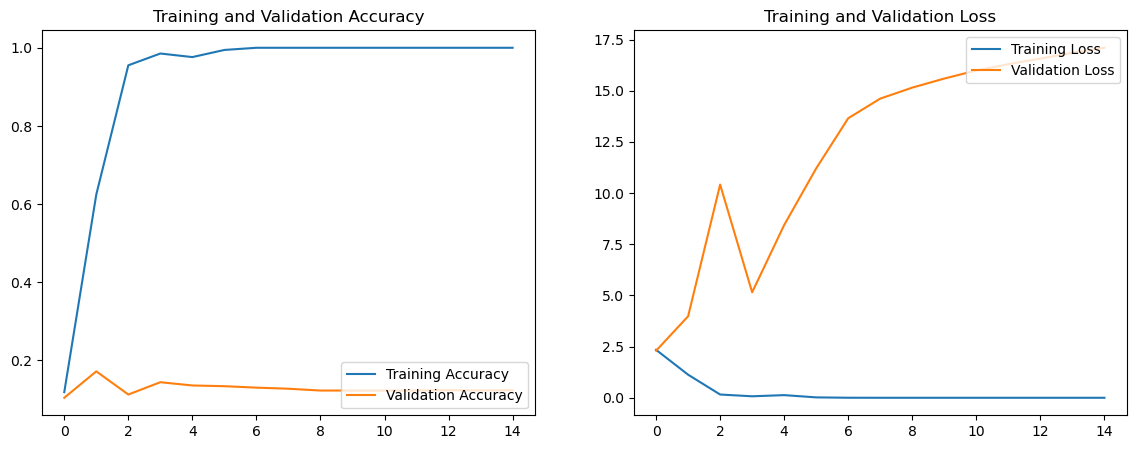

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### CNN+LSTM
- 이건 ppt에 안넣어도 될 것 같아요

In [ ]:
Model = Sequential()

Model.add(SeparableConv2D(12,(3,3),activation="relu",
                 input_shape=(256,256,3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2,2)))

Model.add(SeparableConv2D(24,(3,3),
                 activation="relu",padding="same"))
Model.add(Dropout(0.2))
Model.add(MaxPooling2D((2,2)))

Model.add(TimeDistributed(Flatten()))
Model.add(Bidirectional(LSTM(64,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))
Model.add(Bidirectional(LSTM(64,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))

Model.add(Flatten())
Model.add(Dense(128,activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(10,activation="softmax"))

In [ ]:
Model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
checkpoint_filepath = 'C:/Users/HOME/Desktop/AI_project/KSL/h5/' + 'best_model_{val_accuracy:.4f}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
history2= Model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    shuffle=True)

Epoch 1/10
20/20 [==============================] - 79s 4s/step - loss: 2.3396 - accuracy: 0.1175 - val_loss: 2.3019 - val_accuracy: 0.1111
Epoch 2/10
20/20 [==============================] - 87s 4s/step - loss: 2.2692 - accuracy: 0.1512 - val_loss: 2.3025 - val_accuracy: 0.0926
Epoch 3/10
20/20 [==============================] - 77s 4s/step - loss: 1.9466 - accuracy: 0.3024 - val_loss: 2.3056 - val_accuracy: 0.0796
Epoch 4/10
20/20 [==============================] - 90s 5s/step - loss: 1.2316 - accuracy: 0.5532 - val_loss: 2.3040 - val_accuracy: 0.1083
Epoch 5/10
20/20 [==============================] - 72s 4s/step - loss: 0.7859 - accuracy: 0.7139 - val_loss: 2.3024 - val_accuracy: 0.1120
Epoch 6/10
20/20 [==============================] - 84s 4s/step - loss: 0.5282 - accuracy: 0.8048 - val_loss: 2.3171 - val_accuracy: 0.1546
Epoch 7/10
20/20 [==============================] - 73s 4s/step - loss: 0.4270 - accuracy: 0.8560 - val_loss: 2.3396 - val_accuracy: 0.1324
Epoch 8/10
20/20 [==

- cnn만 적용한 것과 다르게 val_loss값이 크게 증가하지는 않지만, 감소하지 않으므르 좋지 않음
- 최고 val_accuracy는 0.1546 (cnn만 적용한 것보다는 크게 나옴)

### CNN+Dropout
- 이것도 ppt에 안넣어도 될 것 같아요

In [ ]:
pool_size = 2
    
model3 = Sequential([
  keras.Input(shape=(256,256,3)),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),                                           
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  MaxPooling2D(pool_size=pool_size),                         

  Flatten(),
  Dense(50),
  Activation('relu'),
  Dropout(0.5),                                          
  
  Dense(10, activation='softmax'),
])

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 256, 256, 30)      840       
                                                                 
 batch_normalization_7 (Batc  (None, 256, 256, 30)     120       
 hNormalization)                                                 
                                                                 
 activation_26 (Activation)  (None, 256, 256, 30)      0         
                                                                 
 conv2d_23 (Conv2D)          (None, 256, 256, 30)      8130      
                                                                 
 batch_normalization_8 (Batc  (None, 256, 256, 30)     120       
 hNormalization)                                                 
                                                                 
 activation_27 (Activation)  (None, 256, 256, 30)     

In [ ]:
model3.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [ ]:
history3= model3.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    shuffle=True)

Epoch 1/15
105/105 [==============================] - 238s 2s/step - loss: 2.7885 - accuracy: 0.1067 - val_loss: 2.3019 - val_accuracy: 0.0926
Epoch 2/15
105/105 [==============================] - 247s 2s/step - loss: 2.3015 - accuracy: 0.1131 - val_loss: 2.3017 - val_accuracy: 0.0926
Epoch 3/15
105/105 [==============================] - 251s 2s/step - loss: 2.2989 - accuracy: 0.1190 - val_loss: 2.3015 - val_accuracy: 0.0926
Epoch 4/15
105/105 [==============================] - 238s 2s/step - loss: 2.2977 - accuracy: 0.1190 - val_loss: 2.3016 - val_accuracy: 0.0926
Epoch 5/15
105/105 [==============================] - 246s 2s/step - loss: 2.2968 - accuracy: 0.1190 - val_loss: 2.3020 - val_accuracy: 0.0926
Epoch 6/15
105/105 [==============================] - 249s 2s/step - loss: 2.2961 - accuracy: 0.1190 - val_loss: 2.3022 - val_accuracy: 0.0926
Epoch 7/15
105/105 [==============================] - 248s 2s/step - loss: 2.2956 - accuracy: 0.1190 - val_loss: 2.3026 - val_accuracy: 0.0926

- 학습이 전혀 되지 않음....?